In [1]:
from pathlib import Path as pt
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

from io import StringIO
import matplotlib.ticker as plticker

In [2]:
def generateNGaussian(N):

    gaussfn = lambda n: f"A{n}*(np.exp((-1.0/2.0)*(((x-cen{n})/sigma{n})**2)))+"
    _gfn, _args = "", "x, "
    for i in range(int(N)): 
        _gfn += gaussfn(i)
        _args += f"cen{i}, A{i}, sigma{i}, "
    exec(f"gfn_ = lambda {_args.strip()[:-1]}: {_gfn.strip()[:-1]}")
    
    return locals()["gfn_"]

def computeNGaussian(wn, inten, sigma=5):

    _args = {}
    N = len(wn)
    gfn = generateNGaussian(N)
    i = 0
    for x, y in zip(wn, inten):
        _args[f"cen{i}"] = x
        _args[f"A{i}"] = y
        _args[f"sigma{i}"] = sigma
        i += 1
    full_wn = np.linspace(wn.min()-100, wn.max()+100, 5000)

    full_inten = gfn(full_wn, **_args)
    return full_wn, full_inten 

In [3]:
from ipywidgets import widgets
from widgetDefinitions import createWidgets
from pathlib import Path as pt

In [5]:
tw = createWidgets(filetype="dat", multiselect=False)

In [42]:
ax = None
def plot_thz(loc, filename, label="CO$^+$: 0$_{1/2}$ --> 1$_{3/2}$"):
    global ax
    loc = pt(loc)
    freq, depletion = np.genfromtxt(loc/filename).T
    
    tw.savefilename.value = pt(filename).stem
    savefile_widget.value = pt(filename).stem
    
    %matplotlib widget
    fig, ax = plt.subplots(figsize=(9, 7), dpi=100)
    tw.fig = fig
    
    ax.plot(freq, depletion, ".-k", lw=0.5)
    
    ax.minorticks_on()
    
    ax.set_xlabel("Frequency (GHz)", fontsize=16)
    ax.set_ylabel("Depletion (%)", fontsize=16)

    ax.tick_params(axis='both', labelsize=16)
    ax.tick_params(which='both', width=2)
    ax.tick_params(which='major', length=7)
    ax.tick_params(which='minor', length=4)

    ax.xaxis.set_major_formatter(plticker.StrMethodFormatter("{x:.3f}"))

    loc = plticker.MaxNLocator(5)
    ax.xaxis.set_major_locator(loc)
    
# D:\SurfDrive\THz_Measurements\CO+\thz\117\EXPORT
# D:\SurfDrive\THz_Measurements\CO+\thz\118\EXPORT
# D:\SurfDrive\THz_Measurements\CO+\thz\253_380\EXPORT
# D:\SurfDrive\THz_Measurements\CO+\thz\253_789\EXPORT

In [4]:
thz_datlocation = pt(r"D:\SurfDrive\THz_Measurements\CO+\thz\117\EXPORT")
thz_dat_files = list(thz_datlocation.glob("*.dat"))
thz_dat_files

[WindowsPath('D:/SurfDrive/THz_Measurements/CO+/thz/117/EXPORT/20_10_20-5.dat'),
 WindowsPath('D:/SurfDrive/THz_Measurements/CO+/thz/117/EXPORT/20_10_20-6.dat'),
 WindowsPath('D:/SurfDrive/THz_Measurements/CO+/thz/117/EXPORT/21_10_20-1.dat'),
 WindowsPath('D:/SurfDrive/THz_Measurements/CO+/thz/117/EXPORT/22_10_20-3.dat'),
 WindowsPath('D:/SurfDrive/THz_Measurements/CO+/thz/117/EXPORT/22_10_20-4.dat'),
 WindowsPath('D:/SurfDrive/THz_Measurements/CO+/thz/117/EXPORT/22_10_20-5.dat'),
 WindowsPath('D:/SurfDrive/THz_Measurements/CO+/thz/117/EXPORT/22_10_20-6.dat'),
 WindowsPath('D:/SurfDrive/THz_Measurements/CO+/thz/117/EXPORT/22_10_20-8.dat'),
 WindowsPath('D:/SurfDrive/THz_Measurements/CO+/thz/117/EXPORT/22_10_20-9.dat'),
 WindowsPath('D:/SurfDrive/THz_Measurements/CO+/thz/117/EXPORT/23_10_20-1.dat'),
 WindowsPath('D:/SurfDrive/THz_Measurements/CO+/thz/117/EXPORT/23_10_20-2.dat'),
 WindowsPath('D:/SurfDrive/THz_Measurements/CO+/thz/117/EXPORT/23_10_20-3.dat'),
 WindowsPath('D:/SurfDrive/T

In [92]:
output = widgets.Output()
savefile_widget = widgets.Text(description="Savefile", value="")
def convert_files(e):
    with output:
        try:
            xmin, xmax = ax.get_xlim()
            filename = pt(tw.files.value)
            location = pt(tw.location.value)
            freq, depletion = np.genfromtxt(location/filename).T
            
            min_ind = np.searchsorted(freq, xmin )
            max_ind = np.searchsorted(freq, xmax )
            
            freq = freq[min_ind:max_ind] # in GHz
            depletion = depletion[min_ind:max_ind]
            
            freq_in_MHz = freq*1000
            
            new_file = location/f"{savefile_widget.value}_in_mhz.dat"
            with open(new_file, "w+") as f:
                f.write(f"# Freq (MHz)\tDepletion(%)\n")
                for wn, inten in zip(freq_in_MHz, depletion):
                    f.write(f"{wn:.3f}\t{inten:.2f}\n")
                
                print(f"{new_file} written")
        except Exception as error:
            print("error occured", error)
        
convert_btn = widgets.Button(description="Convert-->MHz",button_style="success", layout=widgets.Layout(width='20%'), style = {'description_width': 'initial'})
convert_btn.on_click(convert_files)

clear_output = widgets.Button(description="clear output",button_style="danger", layout=widgets.Layout(width='20%'), style = {'description_width': 'initial'})
clear_output.on_click(lambda e: output.clear_output())

In [45]:
display(tw.update_files_button)
out = widgets.interact_manual( plot_thz, loc=tw.location, filename=tw.files)
display(tw.savefilename, tw.savedpi, tw.savebutton, tw.closebutton, tw.output)
display(savefile_widget, convert_btn, clear_output, output)

Button(button_style='success', description='update location', layout=Layout(width='20%'), style=ButtonStyle())

interactive(children=(Text(value='D:\\SurfDrive\\THz_Measurements\\CO+\\thz\\253_380\\EXPORT', description='da…

Text(value='binned_235.375_235.385GHz_14kHz', description='savefilename')

IntText(value=140, description='savedpi', step=2)

Button(button_style='success', description='Save', style=ButtonStyle())

Button(button_style='danger', description='Clear', style=ButtonStyle())

Output(outputs=({'name': 'stdout', 'text': 'Location not set\nGetting dat from D:\\SurfDrive\\THz_Measurements…

Text(value='binned_235.375_235.385GHz_14kHz', description='Savefile')

Button(button_style='success', description='Convert-->MHz', layout=Layout(width='20%'), style=ButtonStyle())

Button(button_style='danger', description='clear output', layout=Layout(width='20%'), style=ButtonStyle())

Output()

In [18]:
location = pt(tw.location.value)
freq, depletion = np.genfromtxt(location/tw.files.value).T

In [24]:
freq_guess = [118.1007, 118.1018, 118.1029]
depletion_guess = [5, 10, 6]
sigma_guess = [1e-4, 1e-3, 1e-4]

init_gueeses = np.array([freq_guess, depletion_guess, sigma_guess]).T.flatten()
N = 3
gfn = generateNGaussian(N)
pop, poc = curve_fit(gfn, freq, depletion, p0=init_gueeses)
perr = np.sqrt(np.diag(poc))
freq_fit = pop[::3]
depletion_fit = pop[1::3]
sigma_fit = pop[2::3]
freq_fit, perr[::3]

NameError: name 'freq' is not defined

In [36]:
freq_guess = [117.6912, 117.6918, 117.6929, 117.6934]
depletion_guess = [4.5, 4.5, 4.5, 4]
sigma_guess = [1e-5, 1e-4, 1e-4, 1e-4]


init_gueeses = np.array([freq_guess, depletion_guess, sigma_guess]).T.flatten()
N = 4
gfn = generateNGaussian(N)
pop, poc = curve_fit(gfn, freq, depletion, p0=init_gueeses)
perr = np.sqrt(np.diag(poc))
freq_fit = pop[::3]
depletion_fit = pop[1::3]
sigma_fit = pop[2::3]
fwhm_fit = 2*np.sqrt(2*np.log(2))*sigma_fit
print(freq_fit, depletion_fit, sigma_fit, fwhm_fit)

[117.69113249 117.69174384 117.69284904 117.6934217 ] [2.92107254 3.45158189 3.82990287 3.33820431] [0.00012949 0.00032748 0.00020106 0.00015968] [0.00030492 0.00077115 0.00047347 0.00037602]


In [41]:
fwhm_fit*1e6

array([304.92311336, 771.1514049 , 473.46721733, 376.02189536])

In [25]:
%matplotlib widget

fig, ax = plt.subplots(figsize=(12, 5), dpi=100)
ax.plot(freq, depletion, ".k", label=f"Experiment")
ax.plot(freq, gfn(freq, *pop), "-k", ms=10, label=f"Fitted")

# ax.set(xlabel="Frequency (GHz)", ylabel="Depletion (%)", title="CO$^+$: 0$_{1/2}$ --> 1$_{3/2}$")
# ax.stem(freq_fit, depletion_fit, use_line_collection=True, linefmt="k")
# ax.legend()
# ax.minorticks_on()
# ax.grid()

ax.set_xlabel("Frequency (GHz)", fontsize=16)
ax.set_ylabel("Depletion (%)", fontsize=16)

for f, d in zip(freq_fit, depletion_fit):
    ax.vlines(x=f, ymin=-4, ymax=2)

# ax.legend(fontsize=16)
ax.minorticks_on()
ax.tick_params(axis='both', labelsize=16)
ax.tick_params(which='both', width=2)
ax.tick_params(which='major', length=7)
ax.tick_params(which='minor', length=4)


ax.xaxis.set_major_formatter(plticker.StrMethodFormatter("{x:.3f}"))

loc = plticker.MaxNLocator(5)
ax.xaxis.set_major_locator(loc)
filename = location/tw.files.value
plt.savefig(f"{location/filename.stem}_fitted.png", dpi=200)
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [27]:
np.linspace(freq[0], freq[-1], 5, endpoint=True), freq[-1]

(array([117.6880275 , 117.69001875, 117.69201   , 117.69400125,
        117.6959925 ]),
 117.69599250000253)

In [65]:
def plot(data, fit_data, scale=1400, plot_fit=False, unit="MHz", save=False):
    
    %matplotlib widget

    fig, ax = plt.subplots(figsize=(9, 7), dpi=100)
    ax.plot(data[0], data[1], ".k", label=f"Experiment")
    if plot_fit:
        ax.plot(fit_data[0], fit_data[1]/scale, "-k", ms=10, label=f"Fitted")

    ax.set_xlabel(f"Frequency ({unit})", fontsize=16)
    ax.set_ylabel("Depletion (%)", fontsize=16)

    ax.minorticks_on()
    ax.tick_params(axis='both', labelsize=16)
    ax.tick_params(which='both', width=2)
    ax.tick_params(which='major', length=7)
    ax.tick_params(which='minor', length=4)

    ax.xaxis.set_major_formatter(plticker.StrMethodFormatter("{x:.3f}"))

    loc = plticker.MaxNLocator(5)
    ax.xaxis.set_major_locator(loc)
    if save:
        plt.savefig(f"{location/filename}_fitted.png", dpi=200)
    plt.show()

In [66]:
location =pt(r"D:\SurfDrive\THz_Measurements\CO+\from_Sandra\CO+_fit_Zeeman")
filename = "117_in_mhz"

data_info = None
with open(location/f"{filename}_fit.dat", "r") as f:
    data_info = f.readlines()

end = 0
for index, line in enumerate(data_info[1:]):
    if "\t" not in line:
        end = index
        break

fit_data = np.genfromtxt(StringIO("".join(data_info[:end]))).T
data = np.genfromtxt(location/f"{filename}.dat").T

scale = 2400
plot(data, fit_data, scale, plot_fit=True, unit="MHz", save=False)

701


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [59]:
plt.savefig(f"{location/filename}.png", dpi=200)

In [30]:
import numpy as np

temp1 = np.array([1, 2, 2])
temp2 = np.array([0.1, 0.5, 0.1])

new_temp2 = temp2.sum()*temp1/temp1.sum()
new_temp2, new_temp2.sum(), temp2.sum()

(array([0.14, 0.28, 0.28]), 0.7, 0.7)

In [35]:
np.append(temp1, np.zeros(5))

array([1., 2., 2., 0., 0., 0., 0., 0.])

In [36]:
temp0 = [1, 2, 3]
temp0.sum()

AttributeError: 'list' object has no attribute 'sum'

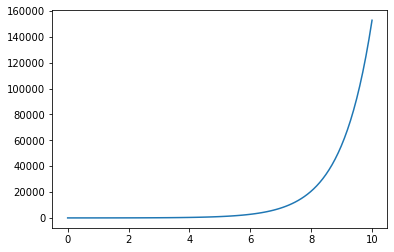

In [63]:
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
def exponential_decay(t, y): 
    y[0] += 1
    return y


sol = solve_ivp(exponential_decay, [0, 10], [2, 4, 8], dense_output=True)
time = np.linspace(0, 10, 100)
y = sol.sol(time)
plt.plot(time, y[0])

TypeError: 'NoneType' object is not callable